In [1]:
# install the dependencies
!pip install kaggle 

In [2]:
from google.colab import files
files.upload() # load kaggle.json file from your computer

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"balnyaupane","key":"f400380eaeb542b5e57a2f135950b57d"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d balnyaupane/small-diabetic-retinopathy-dataset -p /content

100% 188M/188M [00:08<00:00, 17.3MB/s]
100% 188M/188M [00:08<00:00, 22.4MB/s]


In [6]:
!unzip -uq "/content/small-diabetic-retinopathy-dataset.zip" -d "/content/Dataset"

In [7]:
from keras.applications.resnet import ResNet101
from keras.models import Model
from keras.layers import Dense,Dropout
from keras.layers import Flatten
from keras_preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

from keras import regularizers
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D

In [8]:
# image size
img_rows=224
img_colms=224

# loading ResNet101 model
# include_top: whether to include the fully-connected layers at the top of the network.
model=ResNet101(weights='imagenet', include_top=False, input_shape=(img_rows,img_colms,3))

171458560/171446536 [==============================] - 8s 0us/step


In [ ]:
# Layers in ResNet50 midel
#for (i,layer) in enumerate(model.layers):
    #print(str(i)+ " "+layer.__class__.__name__,layer.trainable)

In [ ]:
# layers are by default trainable, so make it non trainable.
for layer in model.layers:
    layer.trainable=False
    
# lets check the layer become trainable=Fale or Not.
#for (i,layer) in enumerate(model.layers):
    #print(str(i)+ " "+layer.__class__.__name__,layer.trainable)

In [ ]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='ResNet50.png')

In [ ]:
# Now adding fully connected Layer on the ResNet101
flatLayer=model.output
#flatLayer = GlobalAveragePooling2D()(flatLayer)
fullConnected=Flatten()(flatLayer)


fullConnected=Dense(16,kernel_regularizer=regularizers.l1_l2(l1=1e-2, l2=1e-4))(fullConnected)
fullConnected=BatchNormalization()(fullConnected)
fullConnected=Activation(activation='relu')(fullConnected)
fullConnected=Dropout(0.4)(fullConnected)


output=Dense(5, activation='softmax')(fullConnected)

print("model.input:  ",model.input)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# Model summarary
model.summary()

model.input:   KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalizat

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.00015,beta_1=0.899,beta_2=0.999,epsilon=1e-07)

# Compile the Model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# trainData_Gen= ImageDataGenerator(rescale=1.0/255.0)

trainData_Gen= ImageDataGenerator()
traindata = trainData_Gen.flow_from_directory(
    directory="/content/Dataset/Diabetic_Retinopathy/training_set",
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical')

print("trainData.class_indices:   ",traindata.class_indices)

testData_Gen= ImageDataGenerator()
testdata = testData_Gen.flow_from_directory(
      directory="/content/Dataset/Diabetic_Retinopathy/test_set",
      target_size=(224,224),
      batch_size=32,
      class_mode='categorical')

print("testdata.class_indices:   ",testdata.class_indices)

Found 1499 images belonging to 5 classes.
trainData.class_indices:    {'0_No_DR': 0, '1_Mild': 1, '2_Moderate': 2, '3_Severe': 3, '4_Proliferate_DR': 4}
Found 440 images belonging to 5 classes.
testdata.class_indices:    {'0_No_DR': 0, '1_Mild': 1, '2_Moderate': 2, '3_Severe': 3, '4_Proliferate_DR': 4}


In [ ]:
History = model.fit(traindata, 
                    validation_data= testdata, 
                    steps_per_epoch=24,
                    epochs=200,
                    validation_steps=14,
                    verbose=1
                 )

Epoch 1/200
24/24 [==============================] - 50s 592ms/step - loss: 44.7751 - accuracy: 0.4310 - val_loss: 28.0486 - val_accuracy: 0.4295
Epoch 2/200
24/24 [==============================] - 11s 443ms/step - loss: 16.2091 - accuracy: 0.5344 - val_loss: 8.9577 - val_accuracy: 0.4909
Epoch 3/200
24/24 [==============================] - 11s 449ms/step - loss: 6.2315 - accuracy: 0.5464 - val_loss: 4.6191 - val_accuracy: 0.5500
Epoch 4/200
24/24 [==============================] - 11s 454ms/step - loss: 3.6642 - accuracy: 0.5917 - val_loss: 3.2897 - val_accuracy: 0.5841
Epoch 5/200
24/24 [==============================] - 11s 464ms/step - loss: 2.9051 - accuracy: 0.5791 - val_loss: 2.9457 - val_accuracy: 0.5432
Epoch 6/200
24/24 [==============================] - 11s 474ms/step - loss: 2.6398 - accuracy: 0.5817 - val_loss: 2.7055 - val_accuracy: 0.5818
Epoch 7/200
24/24 [==============================] - 11s 461ms/step - loss: 2.5492 - accuracy: 0.5617 - val_loss: 2.5522 - val_accura

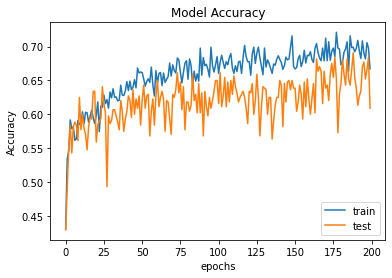

In [ ]:
# summarize history for accuracy
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

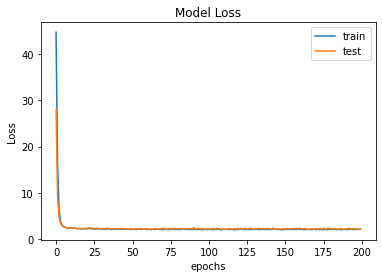

In [ ]:
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# Now adding fully connected Layer on the ResNet101
flatLayer=model.output
#flatLayer = GlobalAveragePooling2D()(flatLayer)
fullConnected=Flatten()(flatLayer)

fullConnected=Dense(32,kernel_regularizer=regularizers.l1_l2(l1=1e-2, l2=1e-4))(fullConnected)
fullConnected=BatchNormalization()(fullConnected)
fullConnected=Activation(activation='relu')(fullConnected)
fullConnected=Dropout(0.5)(fullConnected)

fullConnected=Dense(16,kernel_regularizer=regularizers.l1_l2(l1=1e-2, l2=1e-4))(fullConnected)
fullConnected=BatchNormalization()(fullConnected)
fullConnected=Activation(activation='relu')(fullConnected)
fullConnected=Dropout(0.5)(fullConnected)


output=Dense(5, activation='softmax')(fullConnected)

print("model.input:  ",model.input)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# Model summarary
model.summary()

from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.000025,beta_1=0.899,beta_2=0.999,epsilon=1e-07)

# Compile the Model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# trainData_Gen= ImageDataGenerator(rescale=1.0/255.0)

trainData_Gen= ImageDataGenerator()
traindata = trainData_Gen.flow_from_directory(
    directory="/content/Dataset/Diabetic_Retinopathy/training_set",
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical')

print("trainData.class_indices:   ",traindata.class_indices)

testData_Gen= ImageDataGenerator()
testdata = testData_Gen.flow_from_directory(
      directory="/content/Dataset/Diabetic_Retinopathy/test_set",
      target_size=(224,224),
      batch_size=16,
      class_mode='categorical')

print("testdata.class_indices:   ",testdata.class_indices)

History = model.fit(traindata, 
                    validation_data= testdata, 
                    steps_per_epoch=47,
                    epochs=250,
                    validation_steps=28,
                    verbose=1
                 )

model.input:   KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormaliz

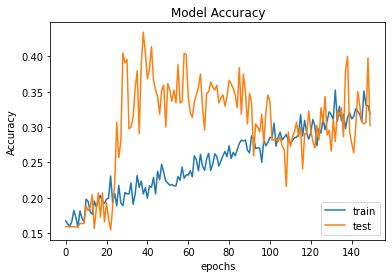

In [ ]:
# summarize history for accuracy
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

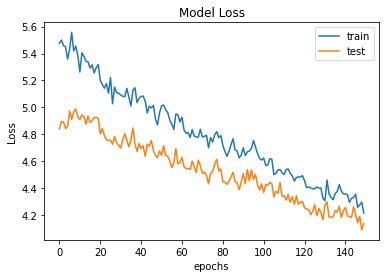

In [ ]:
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# Now adding fully connected Layer on the ResNet101
flatLayer=model.output
#flatLayer = GlobalAveragePooling2D()(flatLayer)
fullConnected=Flatten()(flatLayer)

fullConnected=Dense(32,kernel_regularizer=regularizers.l1_l2(l1=1e-2, l2=1e-4))(fullConnected)
fullConnected=BatchNormalization()(fullConnected)
fullConnected=Activation(activation='relu')(fullConnected)
fullConnected=Dropout(0.5)(fullConnected)

fullConnected=Dense(16,kernel_regularizer=regularizers.l1_l2(l1=1e-2, l2=1e-4))(fullConnected)
fullConnected=BatchNormalization()(fullConnected)
fullConnected=Activation(activation='relu')(fullConnected)
fullConnected=Dropout(0.5)(fullConnected)


output=Dense(5, activation='softmax')(fullConnected)

print("model.input:  ",model.input)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# Model summarary
#model.summary()

from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.00075,beta_1=0.899,beta_2=0.999,epsilon=1e-07)

# Compile the Model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# trainData_Gen= ImageDataGenerator(rescale=1.0/255.0)

trainData_Gen= ImageDataGenerator()
traindata = trainData_Gen.flow_from_directory(
    directory="/content/Dataset/Diabetic_Retinopathy/training_set",
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical')

print("trainData.class_indices:   ",traindata.class_indices)

testData_Gen= ImageDataGenerator()
testdata = testData_Gen.flow_from_directory(
      directory="/content/Dataset/Diabetic_Retinopathy/test_set",
      target_size=(224,224),
      batch_size=32,
      class_mode='categorical')

print("testdata.class_indices:   ",testdata.class_indices)

History = model.fit(traindata, 
                    validation_data= testdata, 
                    steps_per_epoch=24,
                    epochs=150,
                    validation_steps=14,
                    verbose=1
                 )

model.input:   KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Found 1499 images belonging to 5 classes.
trainData.class_indices:    {'0_No_DR': 0, '1_Mild': 1, '2_Moderate': 2, '3_Severe': 3, '4_Proliferate_DR': 4}
Found 440 images belonging to 5 classes.
testdata.class_indices:    {'0_No_DR': 0, '1_Mild': 1, '2_Moderate': 2, '3_Severe': 3, '4_Proliferate_DR': 4}
Epoch 1/150
24/24 [==============================] - 19s 505ms/step - loss: 12.8918 - accuracy: 0.1908 - val_loss: 11.1497 - val_accuracy: 0.2273
Epoch 2/150
24/24 [==============================] - 10s 427ms/step - loss: 10.9573 - accuracy: 0.2048 - val_loss: 10.4434 - val_accuracy: 0.2273
Epoch 3/150
24/24 [==============================] - 10s 429ms/step - loss: 10.4058 - accuracy: 0.1908 - val_loss: 9.7379 - val_accuracy: 0.2273
Epoch 4/150
24/24 [==============================] - 10s 431ms/step - loss: 10.1934 - accur

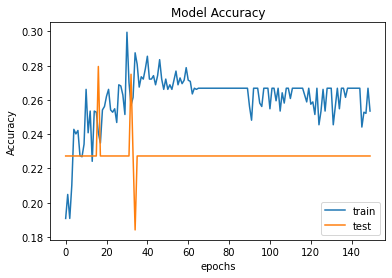

In [ ]:
# summarize history for accuracy
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

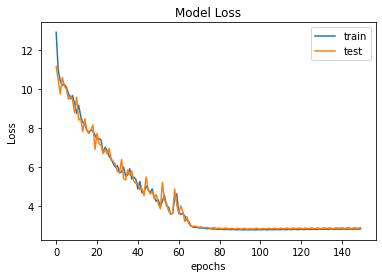

In [ ]:
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [9]:
# making all layer trainable
for layer in model.layers:
    layer.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 155
# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

# lets check the layer become trainable=Fale or Not.
for (i,layer) in enumerate(model.layers):
    print(str(i)+ " "+layer.__class__.__name__,layer.trainable)


flatLayer=model.output
#flatLayer = GlobalAveragePooling2D()(flatLayer)
fullConnected=Flatten()(flatLayer)

fullConnected=Dense(16,kernel_regularizer=regularizers.l1_l2(l1=1e-2, l2=1e-4))(fullConnected)
fullConnected=BatchNormalization()(fullConnected)
fullConnected=Activation(activation='relu')(fullConnected)
fullConnected=Dropout(0.5)(fullConnected)


output=Dense(5, activation='softmax')(fullConnected)

print("model.input:  ",model.input)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# Model summarary
model.summary()

from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.00075,beta_1=0.899,beta_2=0.999,epsilon=1e-07)

# Compile the Model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# trainData_Gen= ImageDataGenerator(rescale=1.0/255.0)

trainData_Gen= ImageDataGenerator()
traindata = trainData_Gen.flow_from_directory(
    directory="/content/Dataset/Diabetic_Retinopathy/training_set",
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical')

print("trainData.class_indices:   ",traindata.class_indices)

testData_Gen= ImageDataGenerator()
testdata = testData_Gen.flow_from_directory(
      directory="/content/Dataset/Diabetic_Retinopathy/test_set",
      target_size=(224,224),
      batch_size=16,
      class_mode='categorical')

print("testdata.class_indices:   ",testdata.class_indices)

History = model.fit(traindata, 
                    validation_data= testdata, 
                    steps_per_epoch=47,
                    epochs=100,
                    validation_steps=28,
                    verbose=1
                 )

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 Activation False
5 ZeroPadding2D False
6 MaxPooling2D False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 Conv2D False
11 BatchNormalization False
12 Activation False
13 Conv2D False
14 Conv2D False
15 BatchNormalization False
16 BatchNormalization False
17 Add False
18 Activation False
19 Conv2D False
20 BatchNormalization False
21 Activation False
22 Conv2D False
23 BatchNormalization False
24 Activation False
25 Conv2D False
26 BatchNormalization False
27 Add False
28 Activation False
29 Conv2D False
30 BatchNormalization False
31 Activation False
32 Conv2D False
33 BatchNormalization False
34 Activation False
35 Conv2D False
36 BatchNormalization False
37 Add False
38 Activation False
39 Conv2D False
40 BatchNormalization False
41 Activation False
42 Conv2D False
43 BatchNormalization False
44 Activation False
45 Conv2D False
46 Conv2D False
47 BatchNormalization False
48 BatchNor

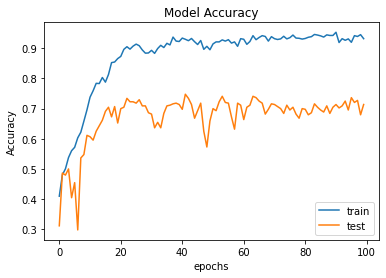

In [10]:
# summarize history for accuracy
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

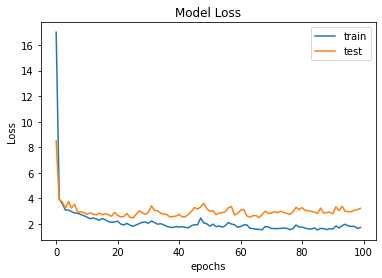

In [11]:
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
from keras.preprocessing import image
import numpy as np
img = image.load_img("D:/Dataset/Diabetic_Retinopathy/test_set/12282_right.jpeg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
output = model.predict(img)
print(np.argmax(output, axis=1))
#print(output)